In [ ]:
# MNIST and ConvNet

In [1]:
### ConvNet: convolutional neural network

# 2 layers heavily used in img processing:

# 1. convolution
# e.g.
# - filter dims == 3x3, filter intensity == 32 (32 different filter patterns, where a patterns is sth like [[1, 1, 1][0, 0, 0], [-1, -1, -1]))
# - take 3x3px from input img, and multiply each px by the intensity of the filter; multiplication results are summed up;
# then propagate to next 3x3px
# - (vs fully connected neural network, where all pxs from orig img are connected to all neurons in next layer)
# - with convolution, we are only connecting first 9pxs of img to 3x3 convolutional neurons: partially connected neural network
# - convolution has a physical meaning: looking for certain features of the orig img

# 2. pooling
# - max pooling: take e.g. 2x2px of orig img => output is the largest value in that 2x2 grid
# - this way at each pooling layer, we are reducing the orig img dimensions by half,
# keeping the strongest signal for propagation.

# often we want a couple of convolution/pooling operations:
# in the 1st convolution layer, since filter is small (3x3), the model will be learning simple/small features which can be represented in 3x3,
# e.g. is the line diagonal, vertical or horizontal (cf tic-tac-toe grid), or what the color is (e.g. intensity of red channel);
# then pooling shrinks the input image
# if we apply a new convolutional layer to the shrunk image, that same layer of 3x3 filter will have access to 6x6px of the original img pxs,
# giving it a "wider perspective" - i.e. ability to learn larger features
# (pooling shrinks the image, but keeps the data/the most intense/important signals/pxs from orig img);
# thus the perspective increases after each convolution/pooling operation, and the model learns more complex/larger shapes/features
# (horizontal line -> arch/eyebrow -> eybrows and eyes -> face)
# 


# %%time # this is not working
# ~3 mins

import tensorflow as tf
from tensorflow.keras.datasets import mnist


# do this after each epoch - useful when you don't know how many epochs it will take to reach certain accuracy:
# this will terminate the fitting/training process as soon as it reaches that accuracy threshold 
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') >
                0.998):  # it actually never reaches this hight accuracy
            print("\nReached 99.8% accuracy so cancelling training!")
            self.model.stop_training = True 


callbacks = myCallback()
mnist = tf.keras.datasets.mnist

(training_images, training_labels), (test_images,
                                     test_labels) = mnist.load_data()

training_images = training_images.reshape(60000, 28, 28, 1)
training_images = training_images / 255.0

test_images = test_images.reshape(10000, 28, 28, 1)
test_images = test_images / 255.0

# another way to initialize the model: provide a list of layers:
model = tf.keras.models.Sequential([
    # first two args to Conv2D: n filters/convolutions, size of the filter
    tf.keras.layers.Conv2D(32, (3, 3),
                           activation='relu',
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # after pooling we often want to have a couple of more convolution/pooling operations (see comments above and below)
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'), # enough to specify input_shape once 
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),    
    tf.keras.layers.Flatten(), # conv2d and maxpooling2d operate on 2d imgs, but then we must flatten for the next dense layer
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()
# Model: "sequential_3"
# ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
# ┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
# ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
# │ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
# ├─────────────────────────────────┼────────────────────────┼───────────────┤
# │ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
# ├─────────────────────────────────┼────────────────────────┼───────────────┤
# │ flatten_3 (Flatten)             │ (None, 5408)           │             0 │
# ├─────────────────────────────────┼────────────────────────┼───────────────┤
# │ dense_6 (Dense)                 │ (None, 128)            │       692,352 │
# ├─────────────────────────────────┼────────────────────────┼───────────────┤
# │ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
# └─────────────────────────────────┴────────────────────────┴───────────────┘
# explanation of above model summary:
# to preserve data from32 filters, we only need 320 floating pt nums
# our dense layer is significantly larger (692,352);
# with convolutions, we can save space and take into account spacial information - which pixels are next to each other in space
# (since data is multidimensional, not flattened as in a fully connected neural network)
 

# with multiple convolution/pooling layers, the model takes up much less space:
# ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
# ┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
# ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
# │ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
# ├─────────────────────────────────┼────────────────────────┼───────────────┤
# │ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
# ├─────────────────────────────────┼────────────────────────┼───────────────┤
# │ conv2d_5 (Conv2D)               │ (None, 11, 11, 32)     │         9,248 │
# ├─────────────────────────────────┼────────────────────────┼───────────────┤
# │ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
# ├─────────────────────────────────┼────────────────────────┼───────────────┤
# │ conv2d_6 (Conv2D)               │ (None, 3, 3, 32)       │         9,248 │
# ├─────────────────────────────────┼────────────────────────┼───────────────┤
# │ max_pooling2d_6 (MaxPooling2D)  │ (None, 1, 1, 32)       │             0 │
# ├─────────────────────────────────┼────────────────────────┼───────────────┤
# │ flatten_4 (Flatten)             │ (None, 32)             │             0 │
# ├─────────────────────────────────┼────────────────────────┼───────────────┤
# │ dense_8 (Dense)                 │ (None, 128)            │         4,224 │
# ├─────────────────────────────────┼────────────────────────┼───────────────┤
# │ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
# └─────────────────────────────────┴────────────────────────┴───────────────┘
#
# input is a 28x28 img

# during convolution, we apply 32 different filters 
# (filters of different patterns, eg [[1, 1, 1], [0, 0, 0], [-1, -1, -1]] - for vertical lines, another one for diagonal lines,
# another one for different colors)
# each of them is 3x3px
# looking for 32 strongest 3x3 patterns;
# convolutional operation is just multiplying vals of pixels and filter and summing everything up:
# the result is the sum of 9 multiplications
# if the filter pattern  matches the 3x3px of original img, you get a high value
# the layer will not look like original img - it will only highligh places on orig img where this particular feature was found;
#
# main purpose of pooling is to reduce dimentionality/amount of computation
# spacially, different recognized patterns (from applying filters) get closer to each other,
# so in the next convolutional layer, more complex patterns get recognized

# filter should remain small
# pooling reduces n of operations for img processing, but most useful information is propagated
# since it's picking the px of highest intensity;
# this gives the next convolutional layer larger view of the original img, and it's not looking at original filter,
# but at the already recognized features, combining them into more complex patterns

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(training_images,
          training_labels,
          epochs=10,
          validation_data=(test_images, test_labels),
          callbacks=[callbacks])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,330 (95.04 KB)

 Trainable params: 24,330 (95.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8140 - loss: 0.5615 - val_accuracy: 0.9694 - val_loss: 0.1021
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9694 - loss: 0.0995 - val_accuracy: 0.9775 - val_loss: 0.0703
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9781 - loss: 0.0696 - val_accuracy: 0.9784 - val_loss: 0.0725
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9837 - loss: 0.0526 - val_accuracy: 0.9805 - val_loss: 0.0595
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9855 - loss: 0.0446 - val_accuracy: 0.9827 - val_loss: 0.0519
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9889 - loss: 0.0352 - val_accuracy: 0.9813 - val_loss: 0.0628
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9903 - loss: 0.0318 - val_accuracy: 0.9827 - val_loss: 0.0581
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9916 - loss: 0

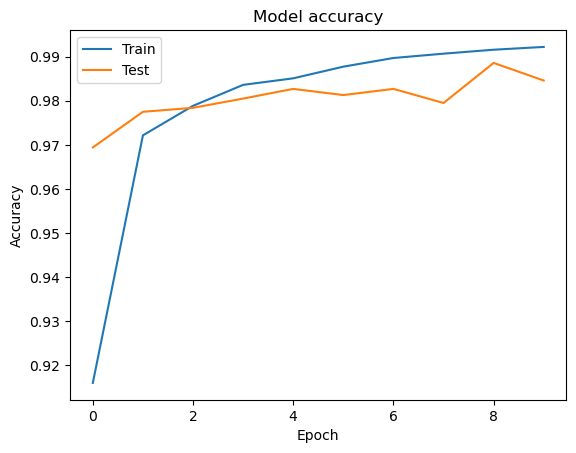

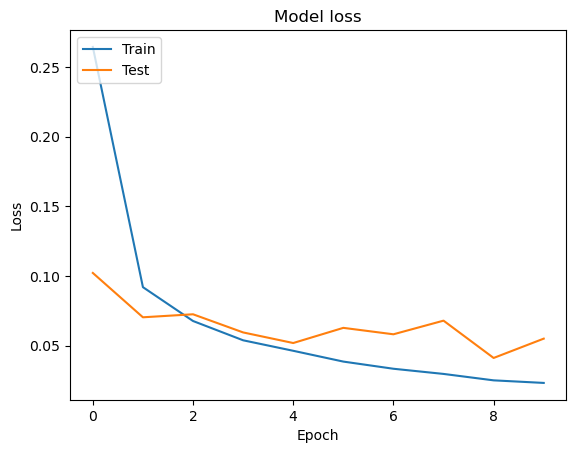

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

history = model.history.history

# Plot training & validation accuracy values
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [5]:
# Model Accuracy
# - with training, the more epochs, the higher the accuracy
# - with tests, it is quickly stabilized and shows lower accuracy than the training dataset
# - must be careful with validation accuracy: **overfeeding**
#   - sometimes, instead of stabiliizing, it can start going down - that's an indicator of overfeeding:
#   - our model is drastically changing weights to recognize imgs from the training data sets that it starts ignoring anything new:
#     we are showing the training data set to model over and over again (overfeeding it)
#     that we are fine-tuning it for those particular imgs/features;
#     Overfeeding can also be observed with loss func:
#     - test loss goes down, then it is stabilized, and then starts going up again
#     - stop training at point where loss was at minimum